In [ ]:
# Computation Part: Run experiments and save results to Google Drive

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import pandas as pd
import itertools
import time

# Create directories in Google Drive
base_folder = '/content/drive/My Drive/ARTL'
experiment_folder = os.path.join(base_folder, 'validation_experiment')
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Data generation function
def generate_data(n=100, noise_std=0.2, outlier_ratio=0.03):
    x1 = np.linspace(0, 2*np.pi, int(np.sqrt(n)))
    x2 = np.linspace(0, 2*np.pi, int(np.sqrt(n)))
    x1_grid, x2_grid = np.meshgrid(x1, x2)
    x1_flat, x2_flat = x1_grid.flatten(), x2_grid.flatten()
    X = np.vstack((x1_flat, x2_flat)).T
    y_true = np.sin(2 * x1_flat) * np.cos(2 * x2_flat)
    y = y_true + np.random.normal(0, noise_std, x1_flat.shape[0])
    n_outliers = int(n * outlier_ratio)
    random_indices = np.random.choice(n, n_outliers, replace=False)
    y[random_indices] = 5 + np.random.uniform(-0.1, 0.1, n_outliers)
    return X, y, y_true, random_indices

# Neural network definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, activation_func='sigmoid'):
        super(NeuralNetwork, self).__init__()
        self.first = nn.Linear(input_dim, 100)
        self.hidden1 = nn.Linear(100, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.hidden3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)
        if activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.first(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        return self.output(x)

# HOVR regularization
def hovr_regularization(model, x, k=3, q=2, M=10):
    x_min, x_max = x.min(0)[0], x.max(0)[0]
    random_points = torch.tensor(
        np.random.uniform(x_min.detach().numpy(), x_max.detach().numpy(), (M, x.shape[1])),
        dtype=torch.float32, requires_grad=True)
    preds = model(random_points)
    grads = torch.autograd.grad(preds, random_points, torch.ones_like(preds),
                                create_graph=True)[0]
    hovr_term = 0.0
    n_dims = x.shape[1]
    for i in range(n_dims):
        grad_i = grads[:, i]
        temp_grad = grad_i
        for _ in range(k - 1):
            temp_grad = torch.autograd.grad(temp_grad, random_points,
                                            torch.ones_like(temp_grad),
                                            create_graph=True)[0][:, i]
        hovr_term += (1 / n_dims) * torch.sum(torch.abs(temp_grad) ** q)
    return hovr_term

# Transformed TTL + HOVR loss function
def transformed_ttl_hovr_loss(model, xi, x, y, h, lambd, k, q):
    n = x.shape[0]
    preds = model(x)
    residuals = (y - preds).view(-1, 1)
    # Loss function computation
    loss_fit = (1 / n) * torch.sum((residuals - xi) ** 2)
    # T_h(ξ) computation
    xi_squared = xi.view(-1) ** 2
    T_h_xi = (1 / n) * torch.sum(torch.topk(xi_squared, h, largest=False)[0])
    # HOVR term computation
    if lambd > 0 and k > 0:
        hovr_term = lambd * hovr_regularization(model, x, k, q)
    else:
        hovr_term = 0
    # Total loss
    total_loss = loss_fit + T_h_xi + hovr_term
    return total_loss

# Main experiment function
def run_experiments():
    # Define parameter combinations
    k_values = [0, 1, 2, 3]
    q_values = [1, 2]
    lambda_values = [0, 1e-2, 1e-3]
    parameter_combinations = list(itertools.product(k_values, q_values, lambda_values))

    total_combinations = len(parameter_combinations)
    start_time = time.time()

    # Iterate over parameter combinations
    for idx, (k, q, lambd) in enumerate(parameter_combinations):
        pmse_list = []
        val_loss_list = []

        print(f"Processing combination {idx+1}/{total_combinations}: k={k}, q={q}, lambda={lambd}")

        # Repeat experiment 10 times
        for trial in range(10):
            trial_start_time = time.time()

            # Generate data
            X, y, y_true, outlier_indices = generate_data()
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

            # Split data into training and validation sets
            n_samples = X.shape[0]
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            split = int(0.8 * n_samples)
            train_idx, val_idx = indices[:split], indices[split:]
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

            # Initialize model and optimizer
            model = NeuralNetwork()
            n_params = X_train.shape[0]
            xi = nn.Parameter(torch.zeros(n_params, 1), requires_grad=True)
            optimizer = optim.Adam(list(model.parameters()) + [xi], lr=0.01)
            h = int(0.9 * n_params)  # Trimming factor for training
            h_val = int(0.9 * X_val.shape[0])  # Trimming factor for validation
            q_val = 2  # q value for validation loss

            # Training
            epochs = 5000
            for epoch in range(epochs):
                optimizer.zero_grad()
                loss = transformed_ttl_hovr_loss(model, xi, X_train_tensor, y_train_tensor, h, lambd, k, q)
                loss.backward()
                optimizer.step()

            # Validation with trimmed loss
            with torch.no_grad():
                val_preds = model(X_val_tensor)
                residuals = (y_val_tensor - val_preds).view(-1)
                residuals_abs = torch.abs(residuals)
                trimmed_residuals, _ = torch.topk(residuals_abs, h_val, largest=False)
                val_loss = torch.mean(trimmed_residuals ** q_val).item()
                val_loss_list.append(val_loss)

            # Test PMSE
            n_test = 10000
            x1_test = np.random.uniform(0, 2*np.pi, n_test)
            x2_test = np.random.uniform(0, 2*np.pi, n_test)
            X_test = np.vstack((x1_test, x2_test)).T
            y_test_true = np.sin(2 * x1_test) * np.cos(2 * x2_test)
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred = model(X_test_tensor).numpy().flatten()
            pmse = mean_squared_error(y_test_true, y_pred)
            pmse_list.append(pmse)

            # Save model and results
            trial_folder = os.path.join(experiment_folder, f"k{k}_q{q}_lambda{lambd}_trial{trial+1}")
            if not os.path.exists(trial_folder):
                os.makedirs(trial_folder)
            # Save model state_dict
            model_path = os.path.join(trial_folder, 'model.pth')
            torch.save(model.state_dict(), model_path)
            # Save results
            results = {
                'val_loss': val_loss,
                'pmse': pmse
            }
            results_path = os.path.join(trial_folder, 'results.npy')
            np.save(results_path, results)

            # Estimate remaining time
            trial_end_time = time.time()
            elapsed_time = trial_end_time - start_time
            trials_completed = idx * 10 + trial + 1
            total_trials = total_combinations * 10
            avg_time_per_trial = elapsed_time / trials_completed
            remaining_trials = total_trials - trials_completed
            remaining_time = remaining_trials * avg_time_per_trial
            print(f"Trial {trial+1}/10 completed. Estimated time remaining: {remaining_time/60:.2f} minutes.")

        # Save aggregated results for this parameter combination
        combination_results = {
            'k': k,
            'q': q,
            'lambda': lambd,
            'pmse_mean': np.mean(pmse_list),
            'pmse_std': np.std(pmse_list),
            'val_loss_mean': np.mean(val_loss_list),
            'val_loss_std': np.std(val_loss_list)
        }
        combination_results_path = os.path.join(experiment_folder, f"results_k{k}_q{q}_lambda{lambd}.npy")
        np.save(combination_results_path, combination_results)

# Run the experiments
run_experiments()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing combination 1/24: k=0, q=1, lambda=0
Trial 1/10 completed. Estimated time remaining: 47.64 minutes.
Trial 2/10 completed. Estimated time remaining: 48.39 minutes.
Trial 3/10 completed. Estimated time remaining: 48.65 minutes.
Trial 4/10 completed. Estimated time remaining: 48.69 minutes.
Trial 5/10 completed. Estimated time remaining: 48.60 minutes.
Trial 6/10 completed. Estimated time remaining: 48.51 minutes.
Trial 7/10 completed. Estimated time remaining: 48.22 minutes.
Trial 8/10 completed. Estimated time remaining: 47.61 minutes.
Trial 9/10 completed. Estimated time remaining: 47.31 minutes.
Trial 10/10 completed. Estimated time remaining: 47.24 minutes.
Processing combination 2/24: k=0, q=1, lambda=0.01
Trial 1/10 completed. Estimated time remaining: 47.14 minutes.
Trial 2/10 completed. Estimated time remaining: 46.94 minutes.
Trial 3/10 comp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


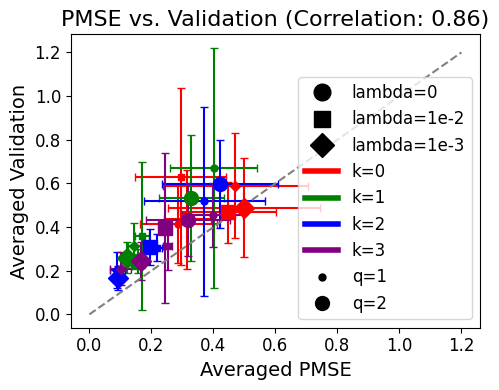

In [ ]:
# Plotting Part: Load results from Google Drive and generate the plot

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the experiment folder
experiment_folder = '/content/drive/My Drive/ARTL/validation_experiment'

# Function to load results
def load_results():
    import glob

    # List all aggregated results files
    result_files = glob.glob(os.path.join(experiment_folder, 'results_k*_q*_lambda*.npy'))
    results = []

    for file in result_files:
        data = np.load(file, allow_pickle=True).item()
        results.append(data)

    df_results = pd.DataFrame(results)
    return df_results

# Modified function with increased font size and label change
def plot_results_with_larger_font(df):
    # Calculate the correlation between 'pmse_mean' and 'val_loss_mean'
    correlation = df['pmse_mean'].corr(df['val_loss_mean'], method='pearson')

    # Create figure and axis with the specified size (5x4)
    fig, ax = plt.subplots(figsize=(5, 4))

    # Define markers for lambda values
    lambda_markers = {0: 'o', 1e-2: 's', 1e-3: 'D'}
    lambda_labels = {0: 'lambda=0', 1e-2: 'lambda=1e-2', 1e-3: 'lambda=1e-3'}

    # Define colors for k values
    k_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}

    # Define sizes for q values
    q_sizes = {1: 50, 2: 100}

    # Plot each point
    for idx, row in df.iterrows():
        ax.errorbar(row['pmse_mean'], row['val_loss_mean'],
                    xerr=row['pmse_std'], yerr=row['val_loss_std'],
                    fmt=lambda_markers[row['lambda']],
                    color=k_colors[row['k']],
                    markersize=q_sizes[row['q']] / 10,
                    capsize=3)

    # Add x=y line in gray
    ax.plot([0, 1.2], [0, 1.2], linestyle='--', color='gray', label='x = y')

    # Create the legend
    lambda_handles = [plt.Line2D([0], [0], marker=marker, color='black', linestyle='None',
                                 markersize=12, label=lambda_labels[lambd]) for lambd, marker in lambda_markers.items()]
    k_handles = [plt.Line2D([0], [0], color=color, lw=4, label=f"k={k}") for k, color in k_colors.items()]
    q_handles = [plt.Line2D([0], [0], marker='o', color='black', linestyle='None',
                            markersize=size/10, label=f"q={q}") for q, size in q_sizes.items()]

    # Combine all legend handles
    handles = lambda_handles + k_handles + q_handles

    # Set labels and legend with larger font sizes and updated labels
    ax.set_xlabel('Averaged PMSE', fontsize=14)
    ax.set_ylabel('Averaged Validation', fontsize=14)

    # Update the title to include the correlation value
    ax.set_title(f'PMSE vs. Validation (Correlation: {correlation:.2f})', fontsize=16)

    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add the legend
    ax.legend(handles=handles, loc='best', fontsize=12)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Load results and plot
df_results = load_results()
plot_results_with_larger_font(df_results)
